In [48]:
import pandas as pd
import numpy as np
import re
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [49]:
# Definisikan kategori Sport, Religion, dan Technology
categories = [
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'alt.atheism',
    'soc.religion.christian'
]

# Ambil dataset dari 20newsgroups
dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes'))
df = pd.DataFrame(dataset.data, columns=["corpus"])
df

,corpus
0,"\nThey tried their best not to show it, believ..."
1,\nStankiewicz? I doubt it.\n\nKoufax was one ...
2,\n[deletia- and so on]\n\nI seem to have been ...
3,"Excuse the sheer newbieness of this post, but ..."
4,==============================================...
...,...
3446,"\n Or, with no dictionary available, they cou..."
3447,\n\nSorry to disappoint you but the Red Wings ...
3448,\n: Can anyone tell me where to find a MPEG vi...
3449,\n


In [50]:
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. filter out words longer than 15 characters
        tokens = [w for w in tokens if len(w) <= 20]
        # 4. join back together
        text = " ".join(tokens)
    text = text.lower().strip()
    return text
df['cleaned'] = df['corpus'].apply(lambda x: preprocess_text(x, remove_stopwords = True))
df

,corpus,cleaned
0,"\nThey tried their best not to show it, believ...",tried best show believe im surprised couldnt f...
1,\nStankiewicz? I doubt it.\n\nKoufax was one ...,stankiewicz doubt koufax one two jewish hofs h...
2,\n[deletia- and so on]\n\nI seem to have been ...,deletia seem rather unclear asking please show...
3,"Excuse the sheer newbieness of this post, but ...",excuse sheer newbieness post looking decent pa...
4,==============================================...,
...,...,...
3446,"\n Or, with no dictionary available, they cou...",dictionary available could gain first hand kno...
3447,\n\nSorry to disappoint you but the Red Wings ...,sorry disappoint red wings earned victoryeasil...
3448,\n: Can anyone tell me where to find a MPEG vi...,anyone tell find mpeg viewer either dos window...
3449,\n,


In [51]:
# Menggunakan Count Vectorizer untuk mengubah teks dokumen menjadi vektor fitur
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned'])

# Ubah array X menjadi matriks sparse CSR
X_sparse = csr_matrix(X)
from sklearn.preprocessing import normalize
X_normalized_sparse = normalize(X_sparse, norm='l2')
# Melakukan K-Means Clustering dengan Euclidean Distance
n_clusters = 3  # Ganti dengan jumlah cluster yang sesuai
kmeans_euclidean = KMeans(n_clusters=n_clusters, random_state=0).fit(X_normalized_sparse)
labels_euclidean = kmeans_euclidean.labels_

print('Hasil K-Means Clustering dengan Euclidean Distance :', labels_euclidean)

/Users/farrelmanazilin/tomatopotato/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Hasil K-Means Clustering dengan Euclidean Distance : [2 2 1 ... 0 2 2]


In [52]:
pca = PCA(n_components=2, random_state=42) 
pca_vecs = pca.fit_transform(X_normalized_sparse.toarray()) 
x0_eu = pca_vecs[:, 0]
x1_eu = pca_vecs[:, 1]
df['x0_eu'] = x0_eu
df['x1_eu'] = x1_eu
df['euclidean'] = labels_euclidean
print(df)

                                                 corpus   
0     \nThey tried their best not to show it, believ...  \
1     \nStankiewicz?  I doubt it.\n\nKoufax was one ...   
2     \n[deletia- and so on]\n\nI seem to have been ...   
3     Excuse the sheer newbieness of this post, but ...   
4     ==============================================...   
...                                                 ...   
3446  \n  Or, with no dictionary available, they cou...   
3447  \n\nSorry to disappoint you but the Red Wings ...   
3448  \n: Can anyone tell me where to find a MPEG vi...   
3449                                                 \n   
3450  \nHey Valentine, I don't see Boston with any w...   

                                                cleaned     x0_eu     x1_eu   
0     tried best show believe im surprised couldnt f...  0.007049  0.001474  \
1     stankiewicz doubt koufax one two jewish hofs h... -0.003413  0.071615   
2     deletia seem rather unclear asking please show..

In [53]:
def get_top_keywords_eu(n_terms):
    df_eu = pd.DataFrame(X_normalized_sparse.todense())
    df_eu["euclidean"] = labels_euclidean
    df_grouped = df_eu.groupby('euclidean').mean()
    terms = vectorizer.get_feature_names_out()
    for i, r in df_grouped.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords_eu(10)
cluster_map = {0: "technology", 1: "religion", 2: "sport"}
df['euclidean'] = df['euclidean'].map(cluster_map)


Cluster 0
using,like,im,program,files,use,file,know,thanks,windows

Cluster 1
bible,like,say,know,believe,think,jesus,dont,people,god

Cluster 2
know,im,time,year,good,team,dont,game,like,think


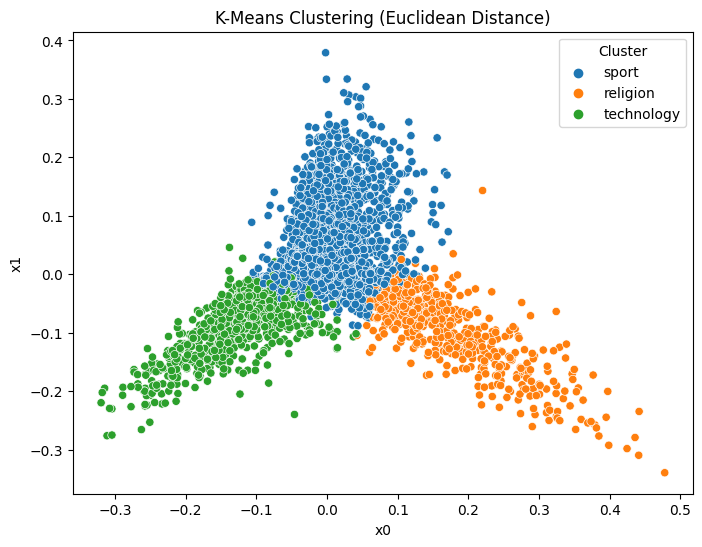

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x=df['x0_eu'], y=df['x1_eu'], hue='euclidean')
plt.title('K-Means Clustering (Euclidean Distance)')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [55]:
# Menghitung Cosine Similarity
cosine_similarities = cosine_similarity(X_normalized_sparse)

# Mengisi diagonal dengan nol pada matriks jarak Cosine Similarity
np.fill_diagonal(cosine_similarities, 0)

# Melakukan K-Means Clustering dengan Cosine Similarity
kmeans_cosine = KMeans(n_clusters=n_clusters, init='k-means++').fit(cosine_similarities)
labels_cosine = kmeans_cosine.labels_

print('Hasil K-Means Clustering dengan Cosine Similarity :', labels_cosine)

/Users/farrelmanazilin/tomatopotato/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Hasil K-Means Clustering dengan Cosine Similarity : [1 1 2 ... 0 1 2]


In [56]:
pca = PCA(n_components=2, random_state=42) 
pca_vecs = pca.fit_transform(cosine_similarities) 
x0_cs = pca_vecs[:, 0]
x1_cs = pca_vecs[:, 1]
df['x0_cs'] = x0_cs
df['x1_cs'] = x1_cs
df['cosine'] = labels_cosine
print(df)

                                                 corpus   
0     \nThey tried their best not to show it, believ...  \
1     \nStankiewicz?  I doubt it.\n\nKoufax was one ...   
2     \n[deletia- and so on]\n\nI seem to have been ...   
3     Excuse the sheer newbieness of this post, but ...   
4     ==============================================...   
...                                                 ...   
3446  \n  Or, with no dictionary available, they cou...   
3447  \n\nSorry to disappoint you but the Red Wings ...   
3448  \n: Can anyone tell me where to find a MPEG vi...   
3449                                                 \n   
3450  \nHey Valentine, I don't see Boston with any w...   

                                                cleaned     x0_eu     x1_eu   
0     tried best show believe im surprised couldnt f...  0.007049  0.001474  \
1     stankiewicz doubt koufax one two jewish hofs h... -0.003413  0.071615   
2     deletia seem rather unclear asking please show..

In [58]:
def get_top_keywords_cs(n_terms):
    df_cs = pd.DataFrame(cosine_similarities)
    df_cs["cosine"] = labels_cosine
    df_grouped = df_cs.groupby('cosine').mean()
    terms = vectorizer.get_feature_names_out()
    for i, r in df_grouped.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords_cs(10)



Cluster 0
atlgant,behaving,aside,alessandros,attached,assigning,bc,accessno,bernie,america

Cluster 1
americanization,bethesda,betrayer,apollo,born,analyst,arent,agrinoenkidumiccl,accountability,believable

Cluster 2
ajf,bitter,alan,arrognace,academia,adds,baby,abolition,annihilation,believable


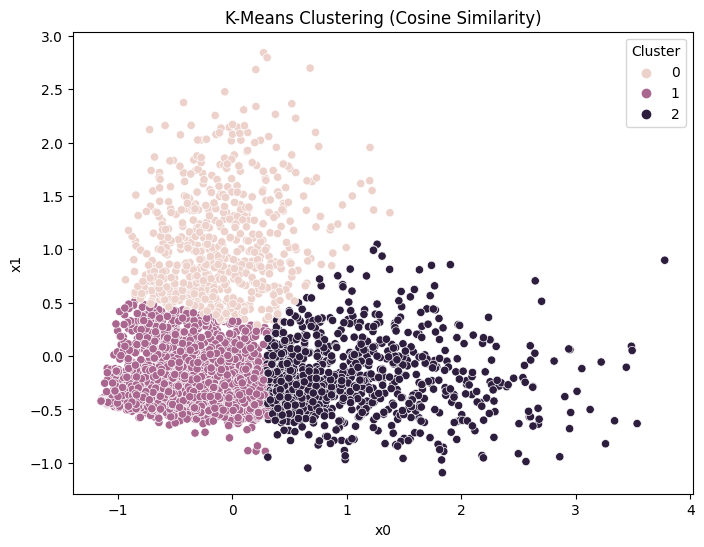

In [60]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x=df['x0_cs'], y=df['x1_cs'], hue='cosine')
plt.title('K-Means Clustering (Cosine Similarity)')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [59]:
# Menghitung DBI dan Silhouette Score
dbi_euclidean = davies_bouldin_score(X_normalized_sparse.toarray(), labels_euclidean)
dbi_cosine = davies_bouldin_score(cosine_similarities, labels_cosine)
silhouette_euclidean = silhouette_score(X_normalized_sparse.toarray(), labels_euclidean, metric='euclidean')
silhouette_cosine = silhouette_score(pairwise_distances(cosine_similarities, metric='cosine'), labels_cosine, metric='precomputed')

# Menampilkan hasil analisis
print("DBI (Euclidean Distance):", dbi_euclidean)
print("DBI (Cosine Similarity):", dbi_cosine)
print("Silhouette Score (Euclidean Distance):", silhouette_euclidean)
print("Silhouette Score (Cosine Similarity):", silhouette_cosine)

# Analisis hasil berdasarkan DBI dan Silhouette Score
if dbi_euclidean < dbi_cosine:
    print("Metode Euclidean Distance lebih baik berdasarkan DBI.")
else:
    print("Metode Cosine Similarity lebih baik berdasarkan DBI.")

if silhouette_euclidean > silhouette_cosine:
    print("Metode Euclidean Distance lebih baik berdasarkan Silhouette Score.")
else:
    print("Metode Cosine Similarity lebih baik berdasarkan Silhouette Score.")

DBI (Euclidean Distance): 8.819862941576746
DBI (Cosine Similarity): 2.305339744213212
Silhouette Score (Euclidean Distance): 0.01207831942785828
Silhouette Score (Cosine Similarity): 0.030193984755760548
Metode Cosine Similarity lebih baik berdasarkan DBI.
Metode Cosine Similarity lebih baik berdasarkan Silhouette Score.
